In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from joblib import Parallel, delayed

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1.5

In [8]:
def log_likelihood(params):
    mu_xt_given_xt_m_1, sigma_xt_given_xt_m_1, mu_x0, sigma_x0 = params

    log_likelihood_x0 = norm.logpdf(xt[0], loc=mu_x0, scale=sigma_x0)
    log_likelihood_xt_given_xt_m_1 = np.sum(norm.logpdf(xt[1:, :], loc=xt[0:-1, :] * mu_xt_given_xt_m_1, scale=sigma_xt_given_xt_m_1))
    
    return -(log_likelihood_x0 + log_likelihood_xt_given_xt_m_1)

def log_likelihood_parallel(params):
    mu_xt_given_xt_m_1, sigma_xt_given_xt_m_1, mu_x0, sigma_x0 = params

    # Log-likelihood for the first data point
    log_likelihood_x0 = norm.logpdf(xt[0], loc=mu_x0, scale=sigma_x0)

    # Parallel computation of the rest of the log-likelihood
    def compute_log_likelihood(t):
        return norm.logpdf(xt[t], loc=xt[t-1] * mu_xt_given_xt_m_1, scale=sigma_xt_given_xt_m_1)
    
    log_likelihood_xt_given_xt_m_1 = Parallel(n_jobs=-1)(delayed(compute_log_likelihood)(t) for t in range(1, T))
    log_likelihood_xt_given_xt_m_1 = np.sum(log_likelihood_xt_given_xt_m_1)

    return -(log_likelihood_x0 + log_likelihood_xt_given_xt_m_1)

In [3]:
T = 100   
k = 1 
beta = np.array([0.5])

mu_e, sigma_e = 0, 1
e = np.random.normal(loc=mu_e, scale=sigma_e, size=T)

mu_x0, sigma_x = 0, sigma_e / (1 - beta[0]**2)
xt = np.zeros((T, k))
xt[0, :] = np.random.normal(loc=mu_x0, scale=sigma_x, size=(1, k))

for t in range(1, T):
    xt[t, :] = beta[0] * xt[t-1, :] + e[t]

<AxesSubplot:ylabel='Count'>

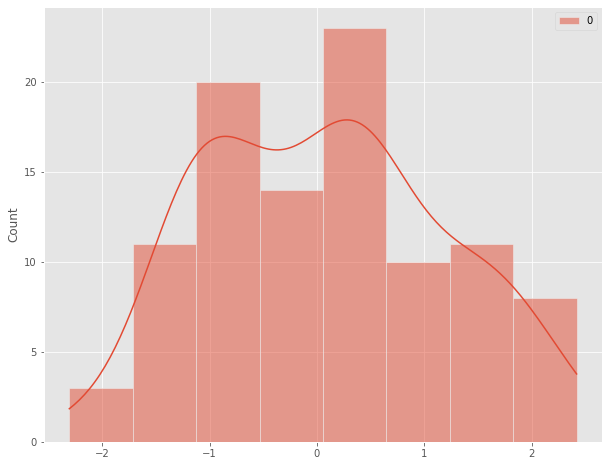

In [4]:
plt.figure(figsize=(10, 8))
sns.histplot(xt, kde=True)

<AxesSubplot:>

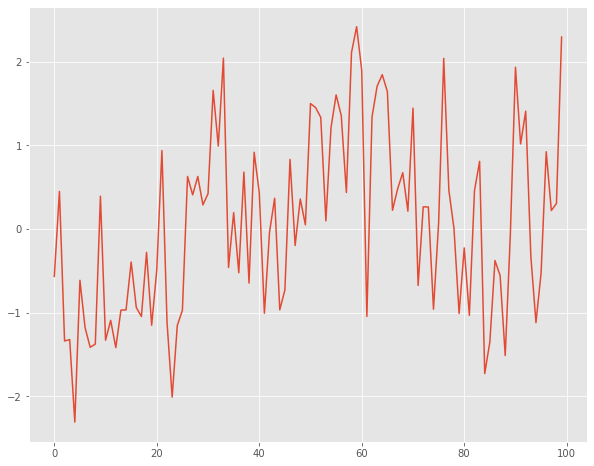

In [5]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(T), y=xt[:, 0])

In [6]:
initial_params = np.random.uniform(-1, 1, 4)

result = minimize(log_likelihood, initial_params, method='L-BFGS-B', bounds=[(-np.inf, np.inf), (1e-5, np.inf), (-np.inf, np.inf), (1e-5, np.inf)])
mu_y_est, sigma_y_est, mu_x_est, sigma_x_est = result.x